# 前提
- 出発点: MCMCはPPLを使えばできるし仕組みもなんとなく分かるけど、細かいところは正直分からない
- 目的: MCMCの仕組みを理解する
  - 仕組みの理解のため、MCMCの中でも簡単なMH法(Metropolis-Hastings)を実装する
- 流れ
  - 1iterを実装する: 初期値からどのようにパラメータが更新されているか確認する
  - 1iterを複数回実行する: 実装した1iterを複数回実行し、どのように普段のMCMCが実装されているか理解する

# データ設定
- 単回帰モデル(y = beta * x)の係数betaを推定する
  - 下記プロットから、bは0.5付近の値を採ることが予想される

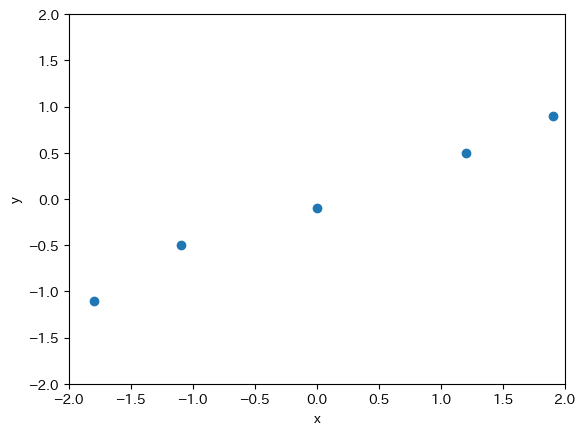

In [32]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# データの準備
np.random.seed(42) # 再現性のためのシード設定
y = np.array([-1.1, -0.5, -0.1, 0.5, 0.9]) 
x = np.array([-1.8,-1.1,0,1.2,1.9]) 

# 散布図のプロット
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

# 1iterの実装
- MH法における1iterを実装し、仕組みを理解する

### 初期値と提案値の設定
- 初期値は0~1の一様分布からランダムに選ぶ
  - 2iter以降は前のiterで採択されたパラメータを用いる
- 提案値は初期値に対して正規分布に従うノイズを加える

In [33]:
beta_current = np.random.rand() # 初期値
print(f'betaの初期値:{beta_current}')

betaの初期値:0.3745401188473625


In [35]:
# 提案分布の定義
# betaに正規分布に従うノイズを加えた値を提案値として返す
def proposal(beta):
    return beta + np.random.normal(0, 0.5) 

beta_proposed = proposal(beta_current) # 提案分布からパラメータをサンプリング
print(f'betaの提案値:{beta_proposed}')

betaの提案値:0.5339912111920542


### 尤度関数の算出
- 誤差は正規分布に従うと仮定

In [36]:
# 尤度関数の定義
# 誤差が正規分布に従うとする
def likelihood(beta, x, y):
    y_pred = beta * x
    sigma = np.std(y - y_pred)
    return np.exp(-0.5 * np.sum(((y - y_pred) / sigma) ** 2)) / (np.sqrt(2 * np.pi * sigma ** 2) ** len(y))

likelihood_current = likelihood(beta_current, x, y) # 初期値の尤度
likelihood_proposed = likelihood(beta_proposed, x, y) # 提案値の尤度
print(f'初期値の尤度:{likelihood_current:1f} \n提案値の尤度:{likelihood_proposed:1f}')

初期値の尤度:1.658912 
提案値の尤度:18.847432


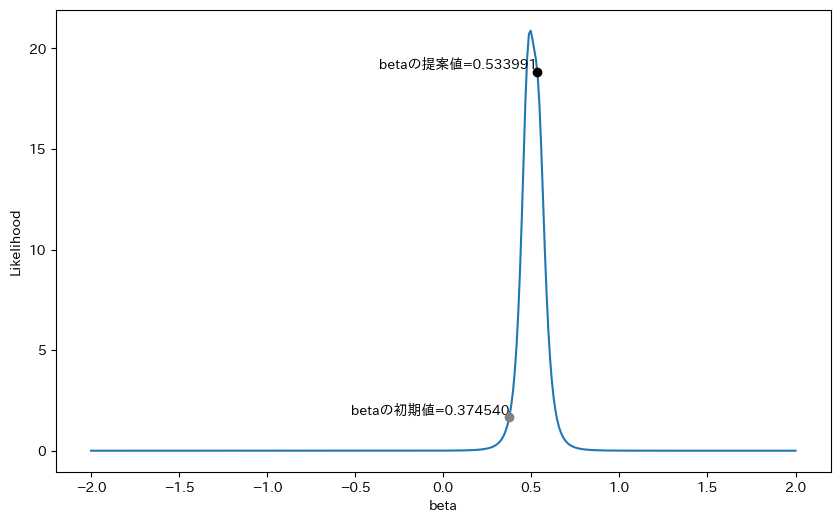

In [37]:
# betaの範囲を設定
beta_values=np.linspace(-2,2,400)

# 各betaに対する尤度の計算
likelihood_values = [likelihood(beta, x, y) for beta in beta_values]

# 尤度関数のグラフ化
plt.figure(figsize=(10, 6))
plt.plot(beta_values, likelihood_values, label='Likelihood Function')
# 初期値のプロット
plt.scatter([beta_current], [likelihood_current], color='gray', zorder=5)
plt.text(beta_current, likelihood_current, f' betaの初期値={beta_current:2f}', verticalalignment='bottom', horizontalalignment='right')
# 提案値のプロット
plt.scatter([beta_proposed], [likelihood_proposed], color='black', zorder=5)
plt.text(beta_proposed, likelihood_proposed, f' betaの提案値={beta_proposed:2f}', verticalalignment='bottom', horizontalalignment='right')

plt.xlabel('beta')
plt.ylabel('Likelihood')
plt.show()

### 事前分布の確率密度関数の算出
- 事前分布として、平均0.5, 標準偏差1の正規分布を置く

In [40]:
# 事前分布の確率密度関数の定義
# 平均0.5, 標準偏差1の正規分布を仮定する
def prior(beta, mu=0.5, sigma=1):
    return np.exp(-0.5 * ((beta - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

prior_current = prior(beta_current) # 初期値の事前分布の確率密度
prior_proposed = prior(beta_proposed) # 提案値の事前分布の確率密度
print(f'初期値の事前分布の確率密度:{prior_current:1f} \n提案値の事前分布の確率密度:{prior_proposed:1f}')

初期値の事前分布の確率密度:0.395815 
提案値の事前分布の確率密度:0.398712


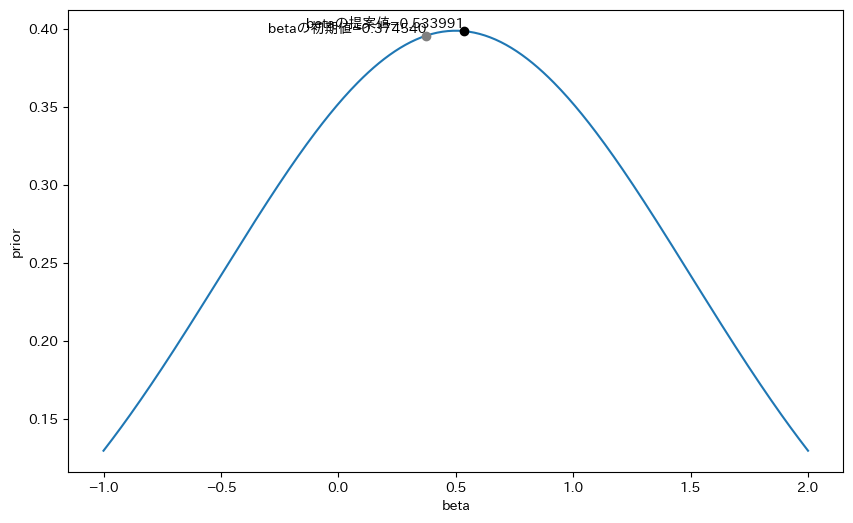

In [44]:
# betaの範囲を設定
beta_values = np.linspace(-1, 2, 400)

# 各betaに対する事前分布の確率密度の計算
prior_values = [prior(beta) for beta in beta_values]

# 事前分布のグラフ化
plt.figure(figsize=(10, 6))
plt.plot(beta_values, prior_values, label='Prior Distribution')

# 初期値のプロット
plt.scatter([beta_current], [prior_current], color='gray', zorder=5)
plt.text(beta_current, prior_current, f' betaの初期値={beta_current:2f}', verticalalignment='bottom', horizontalalignment='right')

# 提案値のプロット
plt.scatter([beta_proposed], [prior_proposed], color='black', zorder=5)
plt.text(beta_proposed, prior_proposed, f' betaの提案値={beta_proposed:2f}', verticalalignment='bottom', horizontalalignment='right')

plt.xlabel('beta')
plt.ylabel('prior')
plt.show()

### 事後分布の確率密度関数の算出
- ベイズの定理より、尤度と事前分布の確率密度の積から、事後分布の確率密度を求める

In [45]:
# 事後分布の確率密度関数の定義
def posterior(likelihood, prior):
    return likelihood * prior

posterior_current = posterior(likelihood_current, prior_current) # 初期値の事後分布の確率密度
posterior_proposed = posterior(likelihood_proposed, prior_proposed) # 提案値の事後分布の確率密度
ratio_posterior = posterior_proposed / posterior_current
print(f'初期値の事後分布の確率密度:{posterior_current:1f} \n提案値の事後分布の確率密度:{posterior_proposed:1f}')
print(f'事後分布の確率密度の比:{ratio_posterior:1f}')

初期値の事後分布の確率密度:0.656622 
提案値の事後分布の確率密度:7.514695
事後分布の確率密度の比:11.444474


### 採択の判定
- 初期値と提案値の事後分布の確率密度の比率を求め、一様分布からの乱数と比較する
  - 事後分布の確率密度の比率が1より大きい場合、提案値を採択
  - 事後分布の確率密度の比率が1より小さい場合
    - 一様分布からの乱数が事後分布の確率密度の比率より小さい場合、提案値を採択 (セカンドチャンス!)
    - 一様分布からの乱数が事後分布の確率密度の比率より大きい場合、初期値を採択

In [46]:
prob_ratio = ratio_posterior # 採択率は事後分布の確率密度の比とする

if prob_ratio >= 1: # 比が1以上の場合は採択
  print('採択')
  beta_current = beta_proposed
elif np.random.rand() < prob_ratio: # 0~1の一様乱数が採択率より小さい場合は採択
  print('採択')
  beta_current = beta_proposed
else: # 比が1未満かつ乱数が採択率より大きい場合は棄却
  print('棄却')
  beta_current = beta_current

print(f'採択したbetaの値:{beta_current:1f}')

採択
採択したbetaの値:0.533991


# 複数iterの実装
- 1iterを複数回実行し、どのように普段のMCMCが実装されているか理解する
- 結果として0.5付近に収束しており、予想通りの結果が得られている

In [49]:
# メトロポリス法の実装
np.random.seed(42) # 再現性のためのシード設定
beta_current = np.random.rand() # 初期値
num_samples = 3000 # サンプリング数
beta_samples = [beta_current] # サンプリング結果を格納するリスト
for i in range(num_samples):
    beta_proposed = proposal(beta_current) # 提案分布からパラメータをサンプリング

    # 尤度算出
    likelihood_current = likelihood(beta_current, x, y) # 現在の尤度
    likelihood_proposed = likelihood(beta_proposed, x, y) # 提案値の尤度

    # 事前分布の確率密度算出
    prior_current = prior(beta_current) # 現在の事前分布の確率密度
    prior_proposed = prior(beta_proposed) # 提案値の事前分布の確率密度

    # 事後分布の確率密度算出
    posterior_current = posterior(likelihood_current, prior_current) # 現在の事後分布の確率密度
    posterior_proposed = posterior(likelihood_proposed, prior_proposed) # 提案値の事後分布の確率密度

    # 採択の判定
    prob_ratio = posterior_proposed / posterior_current # 採択率は事後分布の確率密度の比とする
    if prob_ratio >= 1: # 比が1以上の場合は採択
        beta_current = beta_proposed
    elif np.random.rand() < prob_ratio: # 0~1の一様乱数が採択率より小さい場合は採択
        beta_current = beta_proposed
    else: # 比が1未満かつ乱数が採択率より大きい場合は棄却
        beta_current = beta_current

    beta_samples.append(beta_current) # サンプリング結果を格納

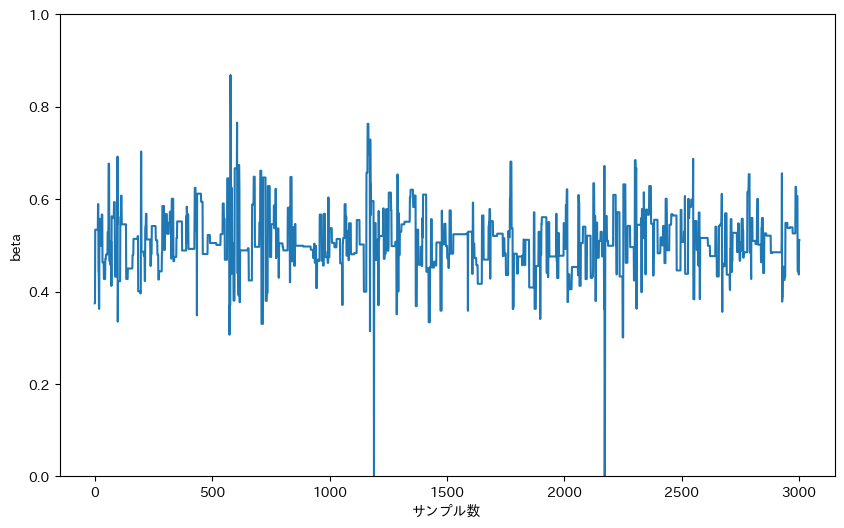

In [50]:
# サンプリング結果の可視化
plt.figure(figsize=(10, 6))
plt.plot(beta_samples)
plt.xlabel('サンプル数')
plt.ylabel('beta')
plt.ylim(0,1)
plt.show()

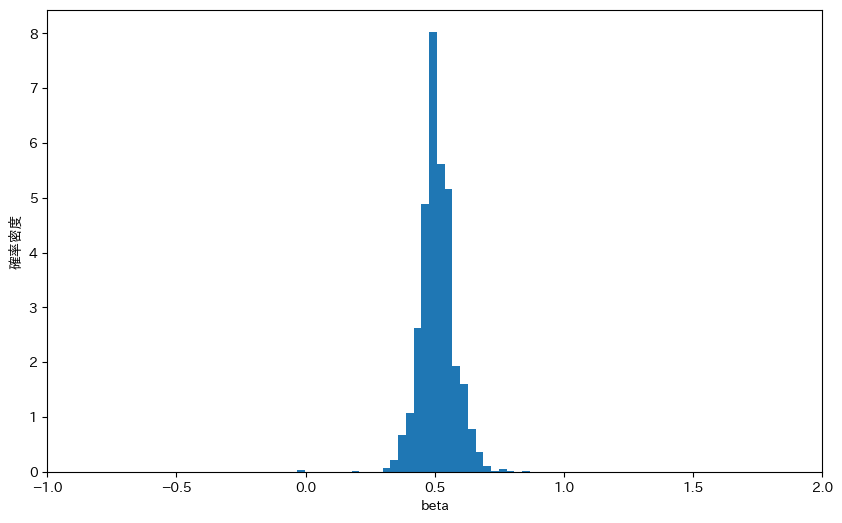

In [53]:
# サンプリング結果のヒストグラム
plt.figure(figsize=(10, 6))
plt.hist(beta_samples, bins=30, density=True)
plt.xlabel('beta')
plt.ylabel('確率密度')
plt.xlim(-1,2)
plt.show()

In [54]:
median = np.median(beta_samples)
percentile_10 = np.percentile(beta_samples, 10)
percentile_90 = np.percentile(beta_samples, 90)
print(f'中央値:{median:1f} \n90パーセンタイル:{percentile_90:1f} \n10パーセンタイル:{percentile_10:1f}')

中央値:0.504450 
90パーセンタイル:0.589342 
10パーセンタイル:0.433295
